In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns 
# from matplotlib.colors import LogNorm
#from matplotlib import rc # make sure we can use TeX in matplotlib
#rc('text', usetex=True)

In [2]:
results = pd.read_csv("results.csv")
configs = pd.read_csv("configs.csv")
order=['Random','Constrained Random','Enumeration','Constrained Enumeration']
results.tail()

FileNotFoundError: [Errno 2] File b'results.csv' does not exist: b'results.csv'

In [33]:
results.loc[:,"strat"].unique()

array(['Linear Random', 'Constrained Linear Random',
       'Constrained Linear Concession', 'Linear Concession'], dtype=object)

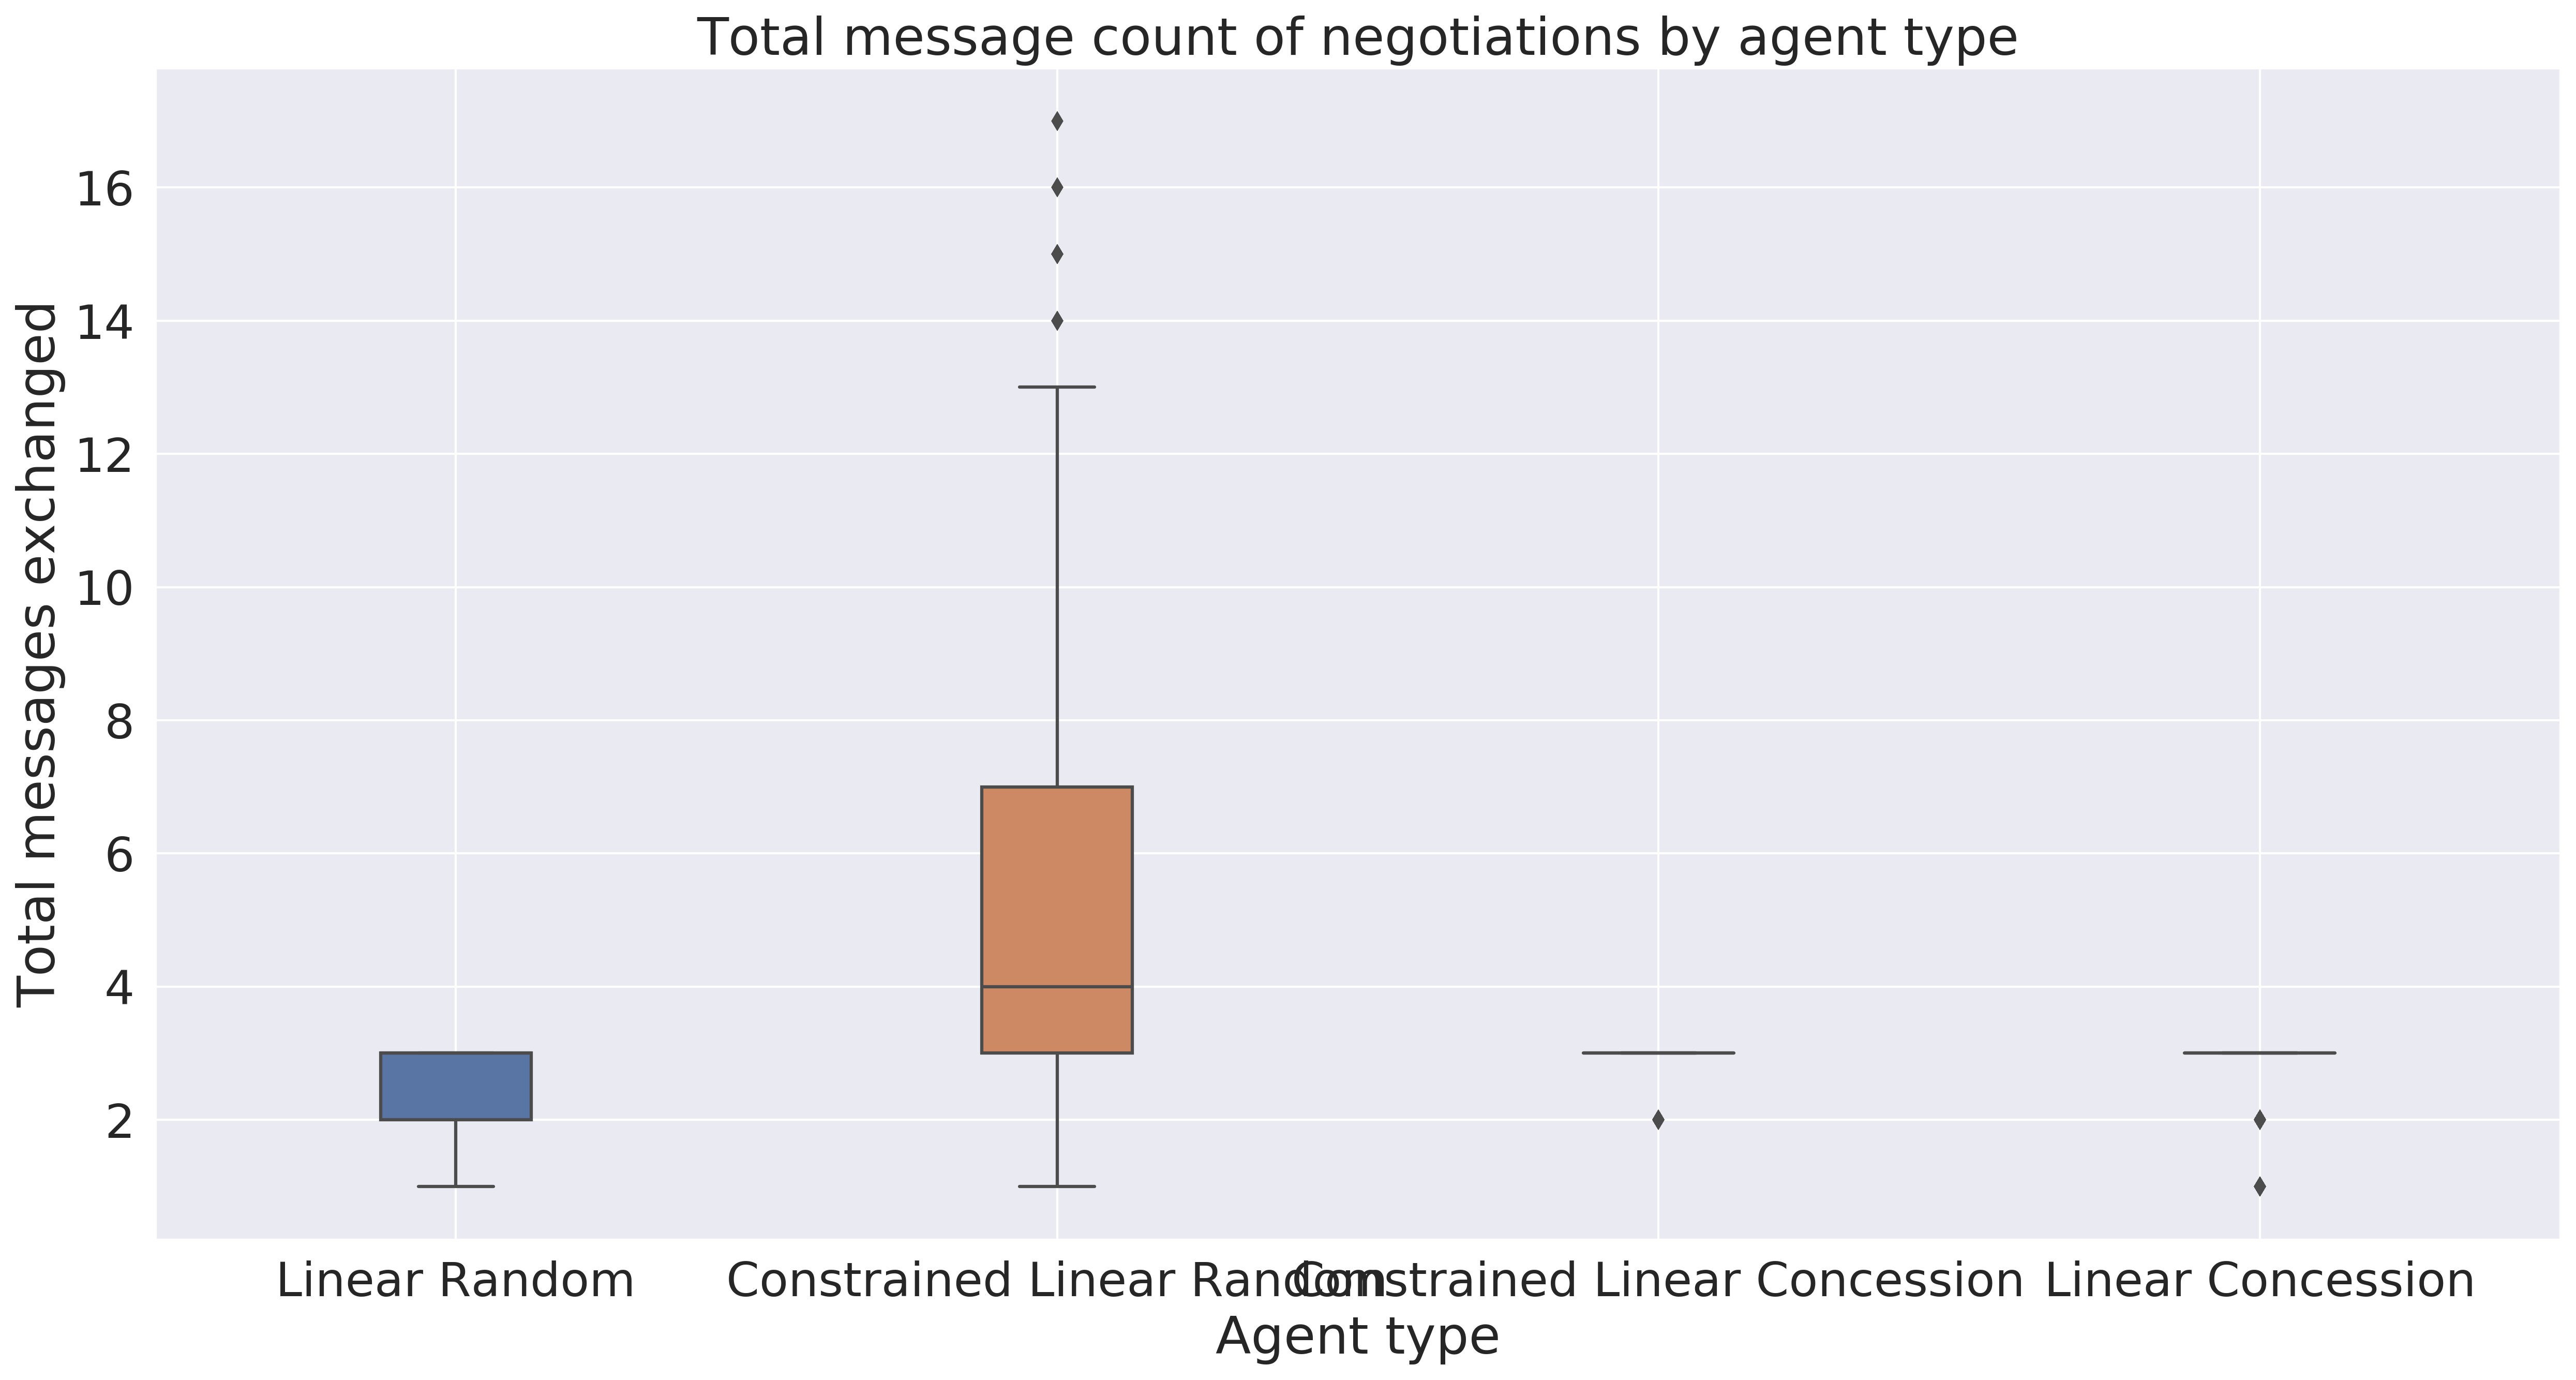

In [24]:
sns.set(font_scale=2)
fig, ax = plt.subplots(1, 1, figsize = (20, 10), dpi=300)
ax = sns.boxplot(x="strat", y="total_message_count", data=results, width=0.25)
ax.set_title(r"Total message count of negotiations by agent type")
ax.set_ylabel('Total messages exchanged')    
ax.set_xlabel('Agent type')
plt.grid(True,"major","both")
plt.show()

## Overall results
In the above boxplot you can see that constrainted enumeration does far and away the best. What is intreaguing that regular enumeration does better than random, and that constrained random doesn't really do better than normal Random. This kind of contradicts both my hypothesis and earlier results. I'll talk about a possible explanation below when I talk about Utility

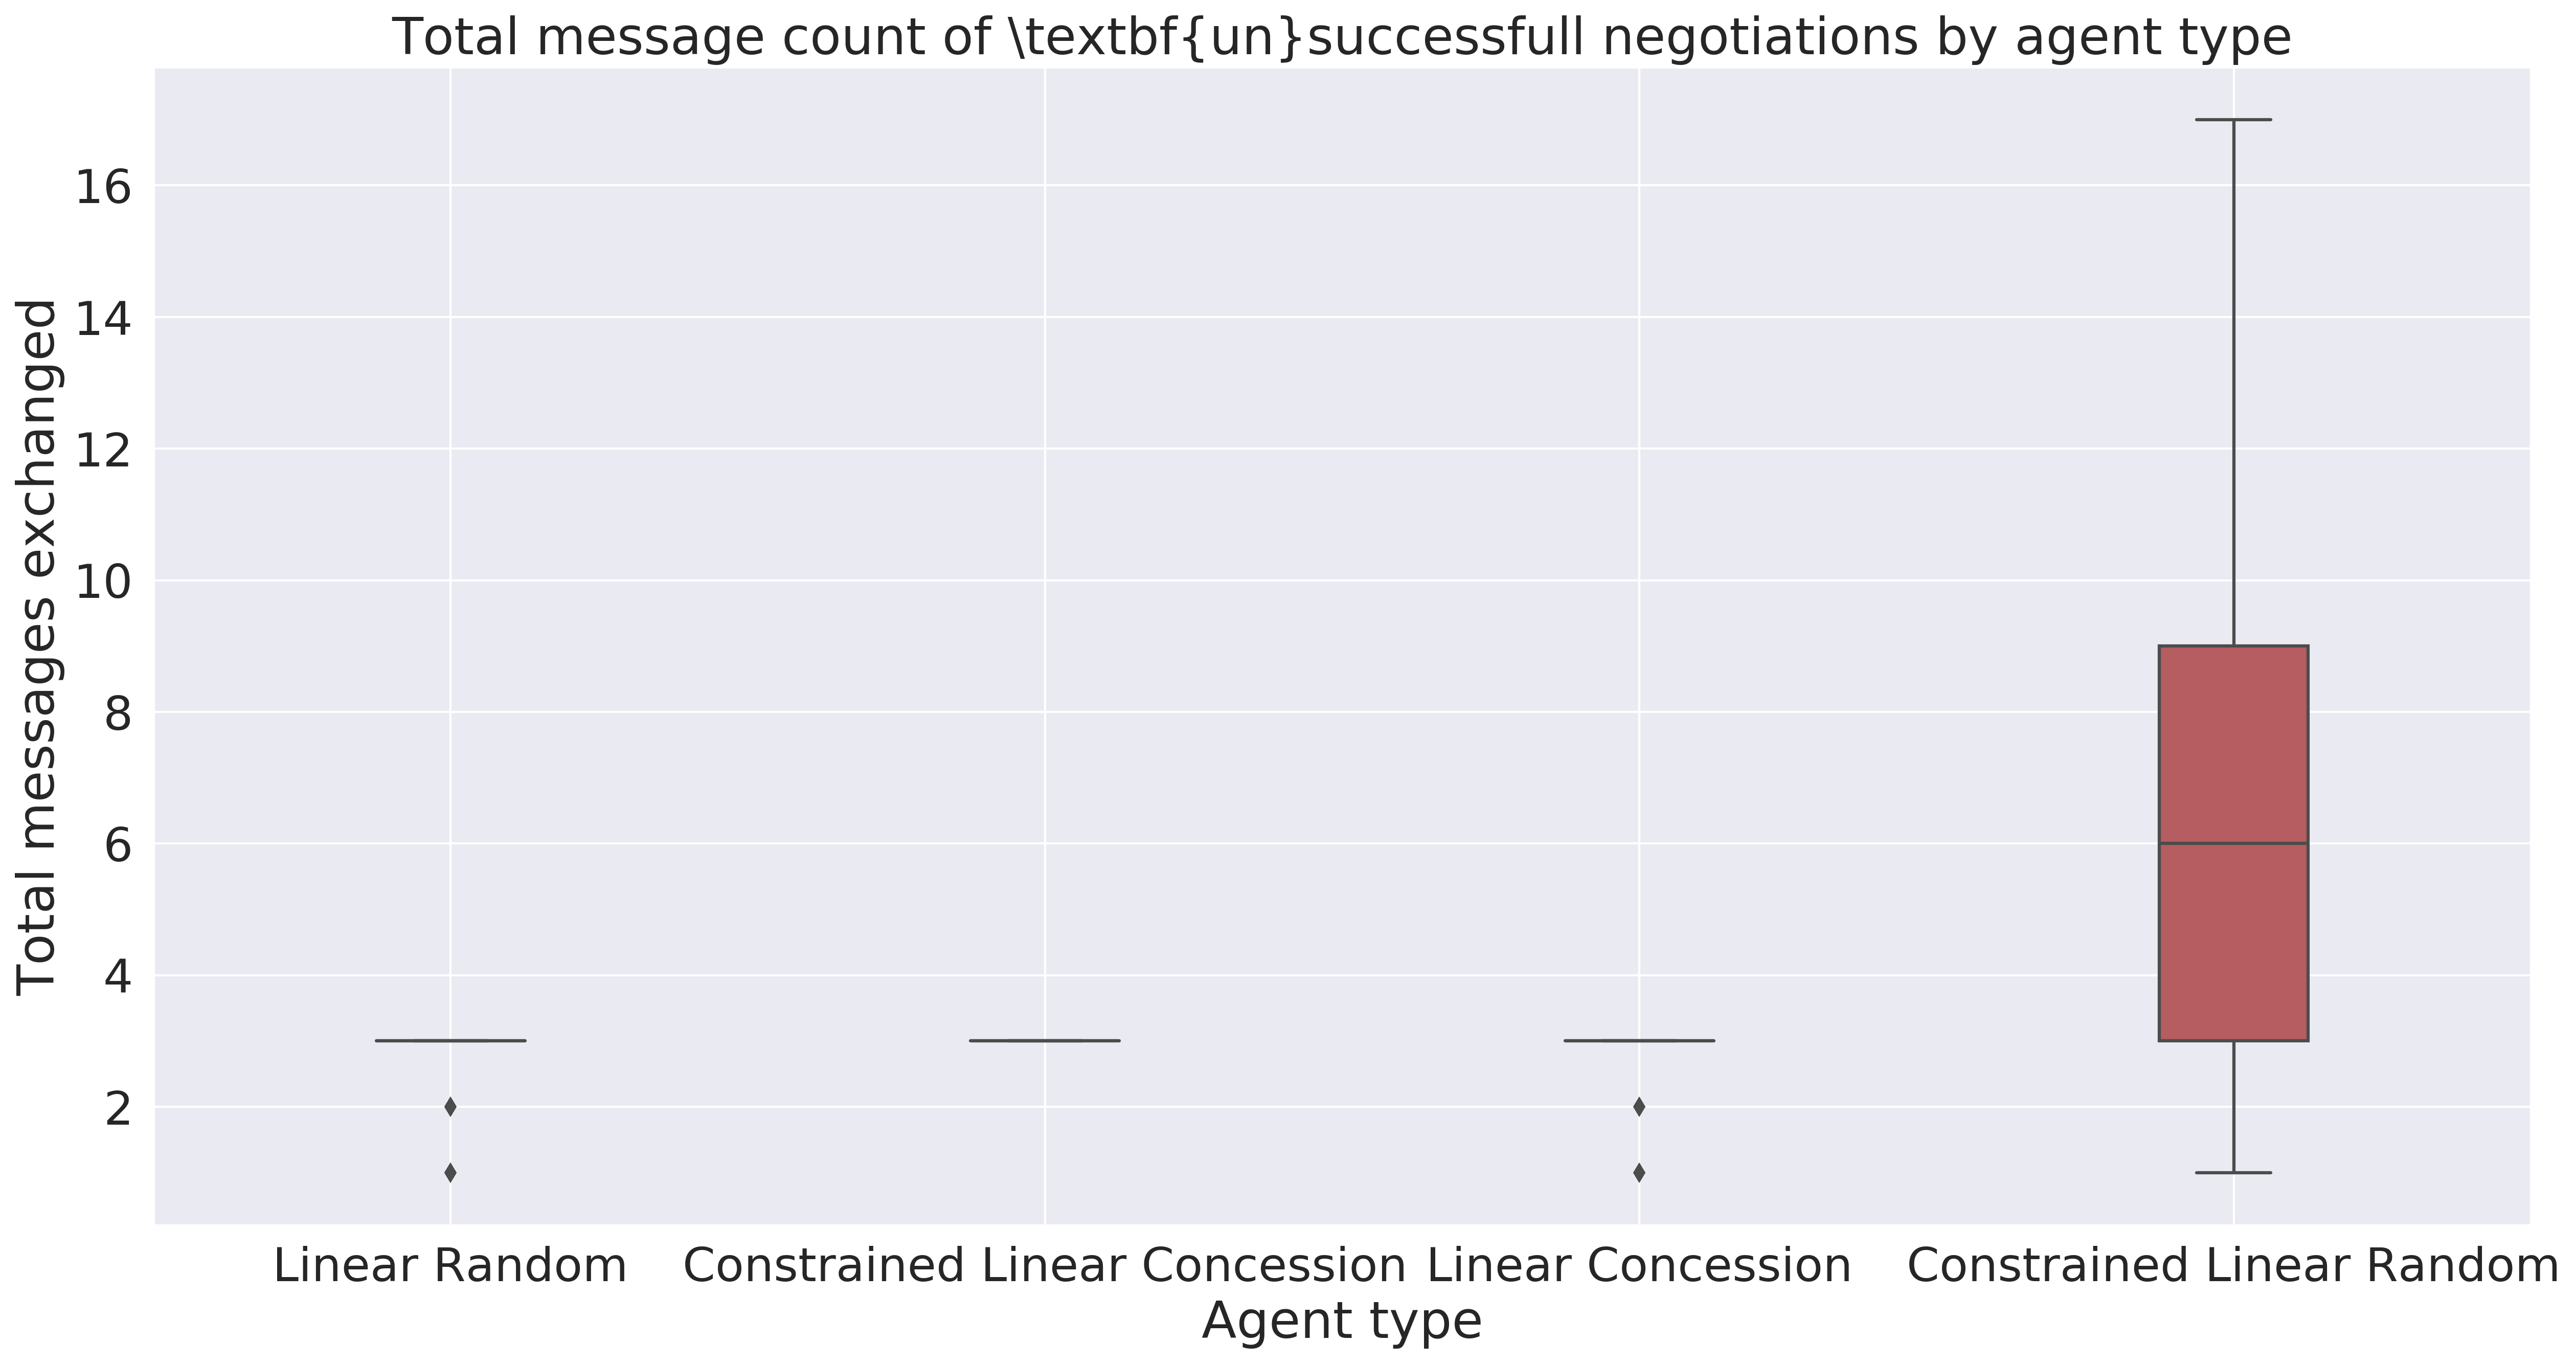

In [25]:
sns.set(font_scale=2)
fig, ax = plt.subplots(1, 1, figsize = (20, 10), dpi=300)
ax = sns.boxplot(x="strat", y="total_message_count", data=results[~results['success']], width=0.25)
ax.set_title(r"Total message count of \textbf{un}successfull negotiations by agent type")
ax.set_ylabel('Total messages exchanged')    
ax.set_xlabel('Agent type')
plt.grid(True,"major","both")
plt.show()

## Unsuccessful negotiatoins
In the event that the negotiations were unsuccessful the constrained methods compleletely outperform the base methods which is pretty much in line with what we expected. 

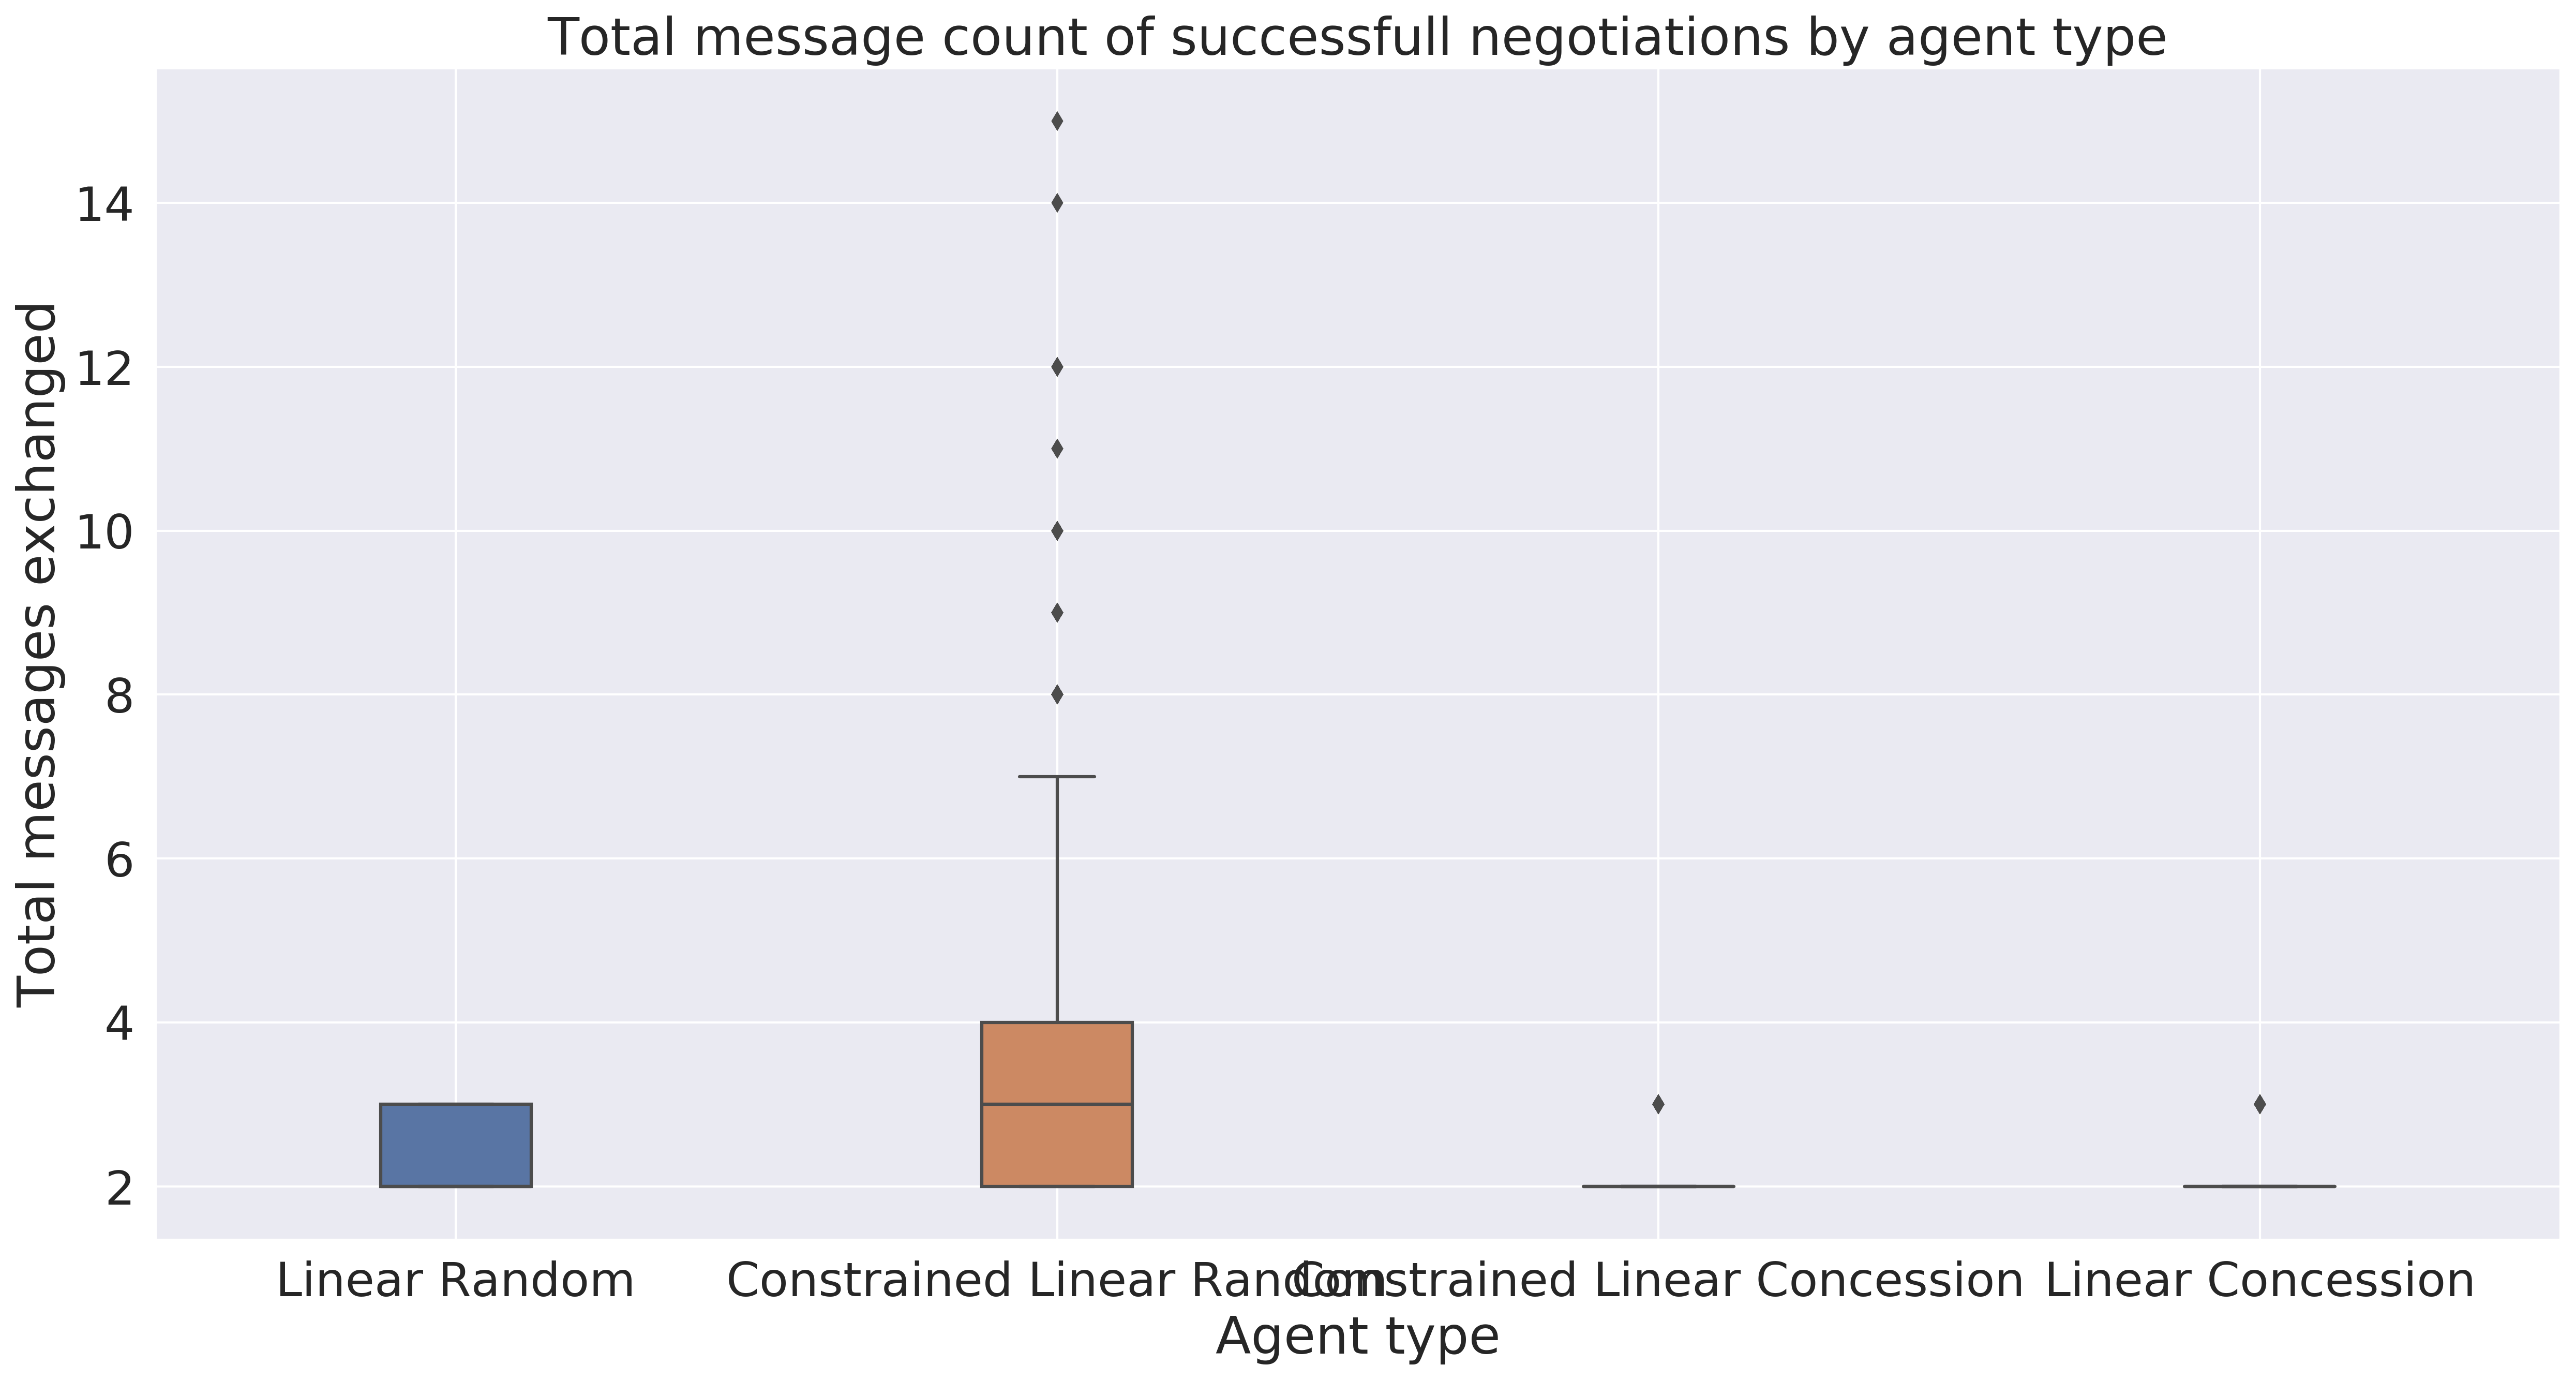

In [26]:
sns.set(font_scale=2)
fig, ax = plt.subplots(1, 1, figsize = (20, 10), dpi=300)
ax = sns.boxplot(x="strat", y="total_message_count", data=results[results['success']], width=0.25)
ax.set_title(r"Total message count of successfull negotiations by agent type")
# ax.set_title(r'\underline{Parameters}: ')
ax.set_ylabel('Total messages exchanged')    
ax.set_xlabel('Agent type')
plt.grid(True,"both","both")
plt.show()

## Successful negotiations
In the sucessful case, we are back to the surprising hirarchy of **Constrained Random** > **Enumeration** > **Random** > **Constrained enumeration**. It's possible that this is caused by bugs, as I'll talk about with then next plot, it is also possible that this is a "true" result. At the very least I think I whould invesitgate why this might be the case

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


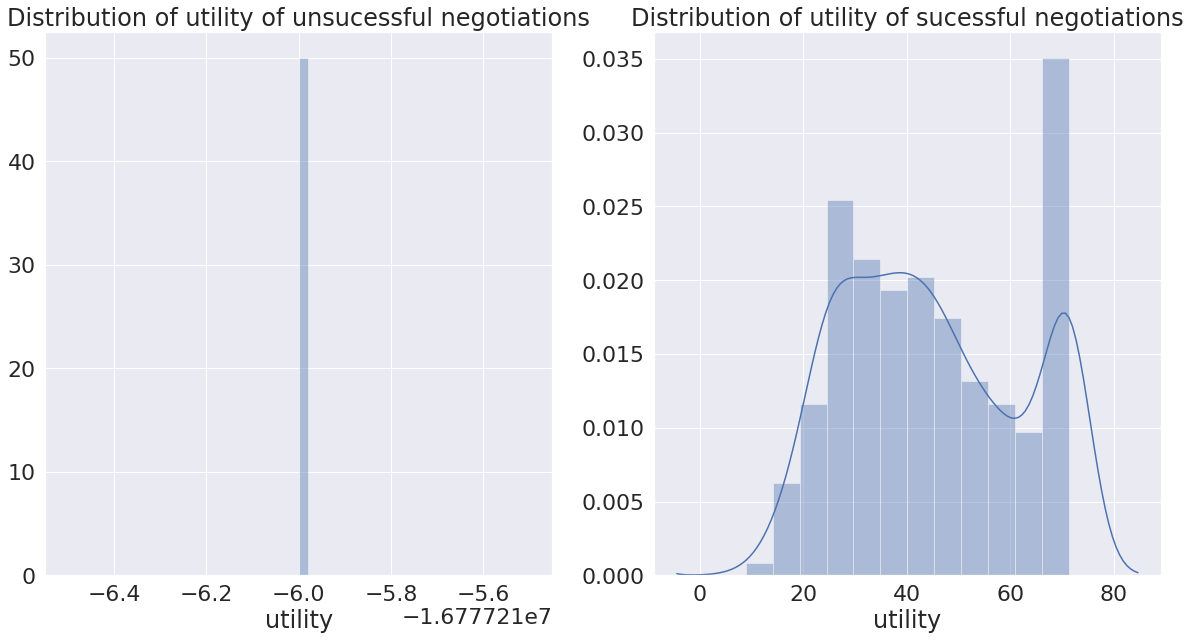

In [31]:
fig, axs = plt.subplots(1, 2,figsize = (20, 10))
sns.distplot(results[~results['success']]['utility'],ax=axs[0])
axs[0].set_title('Distribution of utility of unsucessful negotiations')

sns.distplot(results[results['success']]['utility'],ax=axs[1])
axs[1].set_title('Distribution of utility of sucessful negotiations')

plt.show()

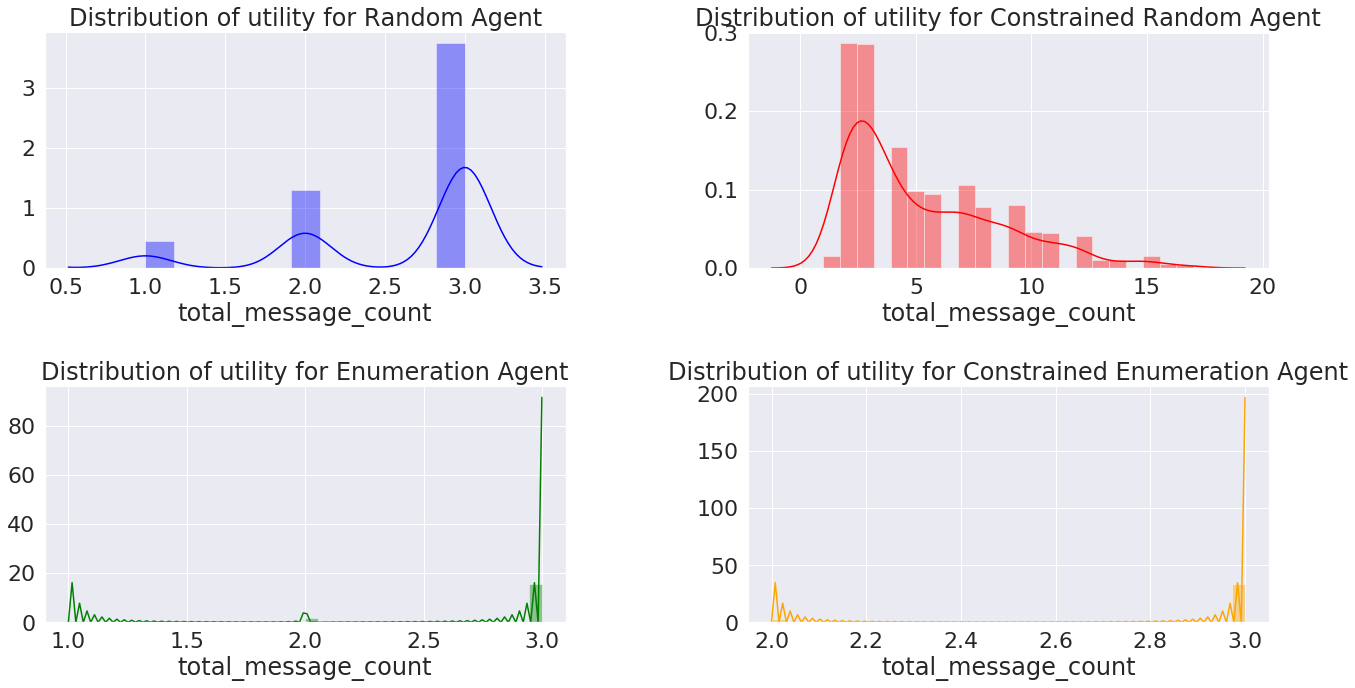

In [36]:
fig, axs = plt.subplots(2, 2,figsize = (20, 10))

sns.distplot(results[(results['strat'] == 'Linear Random')]['total_message_count'],ax=axs[0,0],color="blue")
axs[0,0].set_title('Distribution of utility for Random Agent')

sns.distplot(results[(results['strat'] == 'Constrained Linear Random')]['total_message_count'],ax=axs[0,1],color="red")
axs[0,1].set_title('Distribution of utility for Constrained Random Agent')

sns.distplot(results[(results['strat'] == 'Linear Concession')]['total_message_count'],ax=axs[1,0],color="green")
axs[1,0].set_title('Distribution of utility for Enumeration Agent')

sns.distplot(results[(results['strat'] == 'Constrained Linear Concession')]['total_message_count'],ax=axs[1,1],color="orange")
axs[1,1].set_title('Distribution of utility for Constrained Enumeration Agent')
plt.subplots_adjust(top=0.92, bottom=0.1, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)
plt.show()

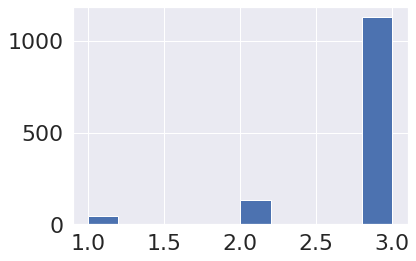

In [38]:
results[results['strat'] == 'Linear Concession']['total_message_count'].hist()

# Utility
Above are two distribution plots of the utilities. First of the unsuccessful ones, and the second of the sucessful ones. Both of the graphs have blibs in places they shouldn't. If the negotiation is unsuccessfull the utility should be extremely negative (non agreement cost) but a few of them are still around 0. Obversly there are a few sucessful negotiations that still have negative utility despite all generated utilities are positive (except for the constraints) indicating that something is wrong in my setup.

## Possible explanations
- It's possible that the cost for the constraints still wasn't enough for it to never be able to part of a negotiation. This has a couple of implications:
    * It's possible that if the constraint value wasn't low enough then the Constrained Random agent didn't actually create enough or any constraints at all in which case it is very possible that it just performed worse or similar by random chance 
    * It also means that sometimes the constrained values could be part of an accepted proposal making the utility below zero. 
    * This also indicates a bug in how the agents reason about whether to accept a proposal 
- I found a bug in the code for the consession/ enumeration agent, so that is possible explanation of why that performs worse for 

In [44]:
util_above_0 = results[results['utility'] >=0].groupby("strat").agg({"success":"count"}).rename(columns={"success": "count of utilities above 0"})
success = results[results['success']].groupby("strat").agg({"success":"count"}).rename(columns={"success": "count of successful negotiations"})
counts = pd.concat([util_above_0,success],axis=1)
counts['diff'] = counts.diff(axis=1).iloc[:,-1]
display(counts)

,count of utilities above 0,count of successful negotiations,diff
strat,,,
Constrained Enumeration,5810,5810,0.0
Constrained Random,16458,16458,0.0
Enumeration,6010,8080,2070.0
Random,10778,9313,-1465.0


The difference column in the above table should be exactly zero. Notice that Enumeration has fasle failures (negotiation is marked as unsuccessful even though utility is above zero) and Random has false successes (vice versa). There are a couple of 1000 failures so I think this indeeds points for flaws in the code. I think this should be investigated and reevaluated before we continue

## Exploration
This is where my well thought out conclusions end. Below is just some exploritory data analysis to help guide my bug hunt I can go into if people are insterested

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


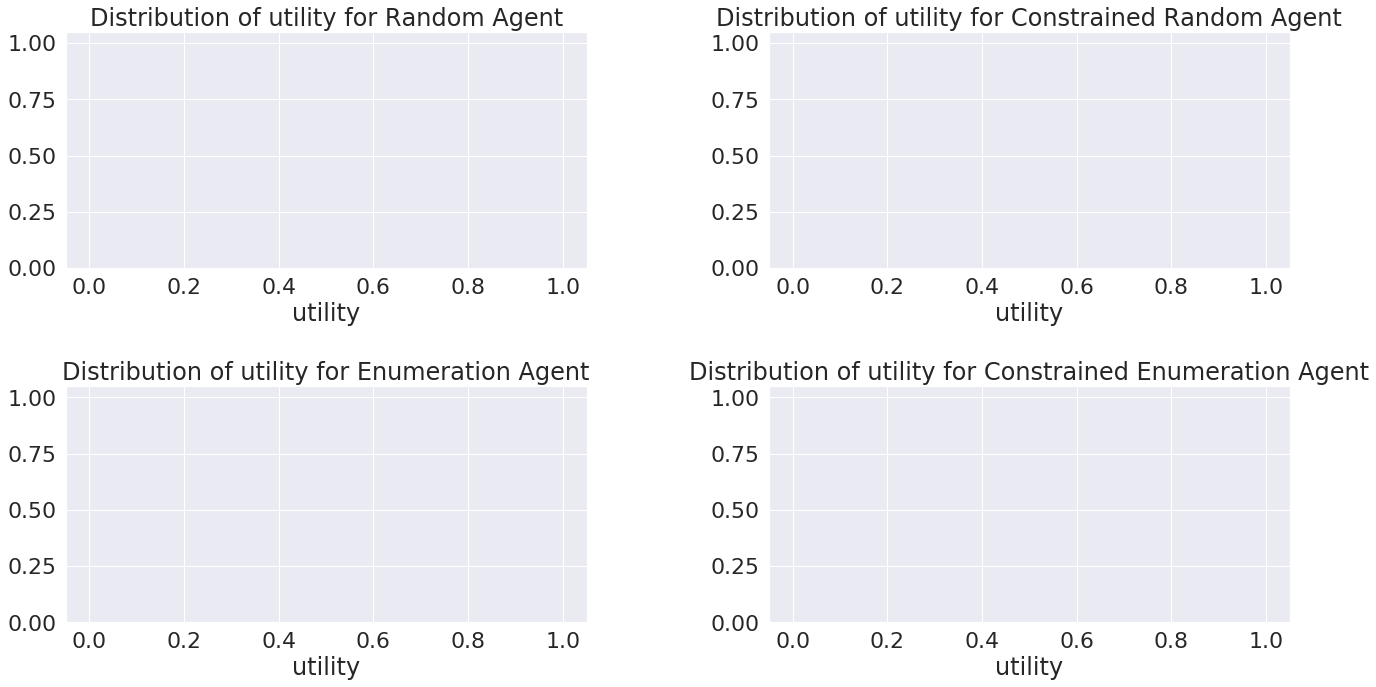

In [30]:
fig, axs = plt.subplots(2, 2,figsize = (20, 10))

sns.distplot(results[(results['strat'] == 'Random')]['utility'],ax=axs[0,0],color="blue")
axs[0,0].set_title('Distribution of utility for Random Agent')

sns.distplot(results[(results['strat'] == 'Constrained Random')]['utility'],ax=axs[0,1],color="red")
axs[0,1].set_title('Distribution of utility for Constrained Random Agent')

sns.distplot(results[(results['strat'] == 'Enumeration')]['utility'],ax=axs[1,0],color="green")
axs[1,0].set_title('Distribution of utility for Enumeration Agent')

sns.distplot(results[(results['strat'] == 'Constrained Enumeration')]['utility'],ax=axs[1,1],color="orange")
axs[1,1].set_title('Distribution of utility for Constrained Enumeration Agent')
plt.subplots_adjust(top=0.92, bottom=0.1, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)
plt.show()

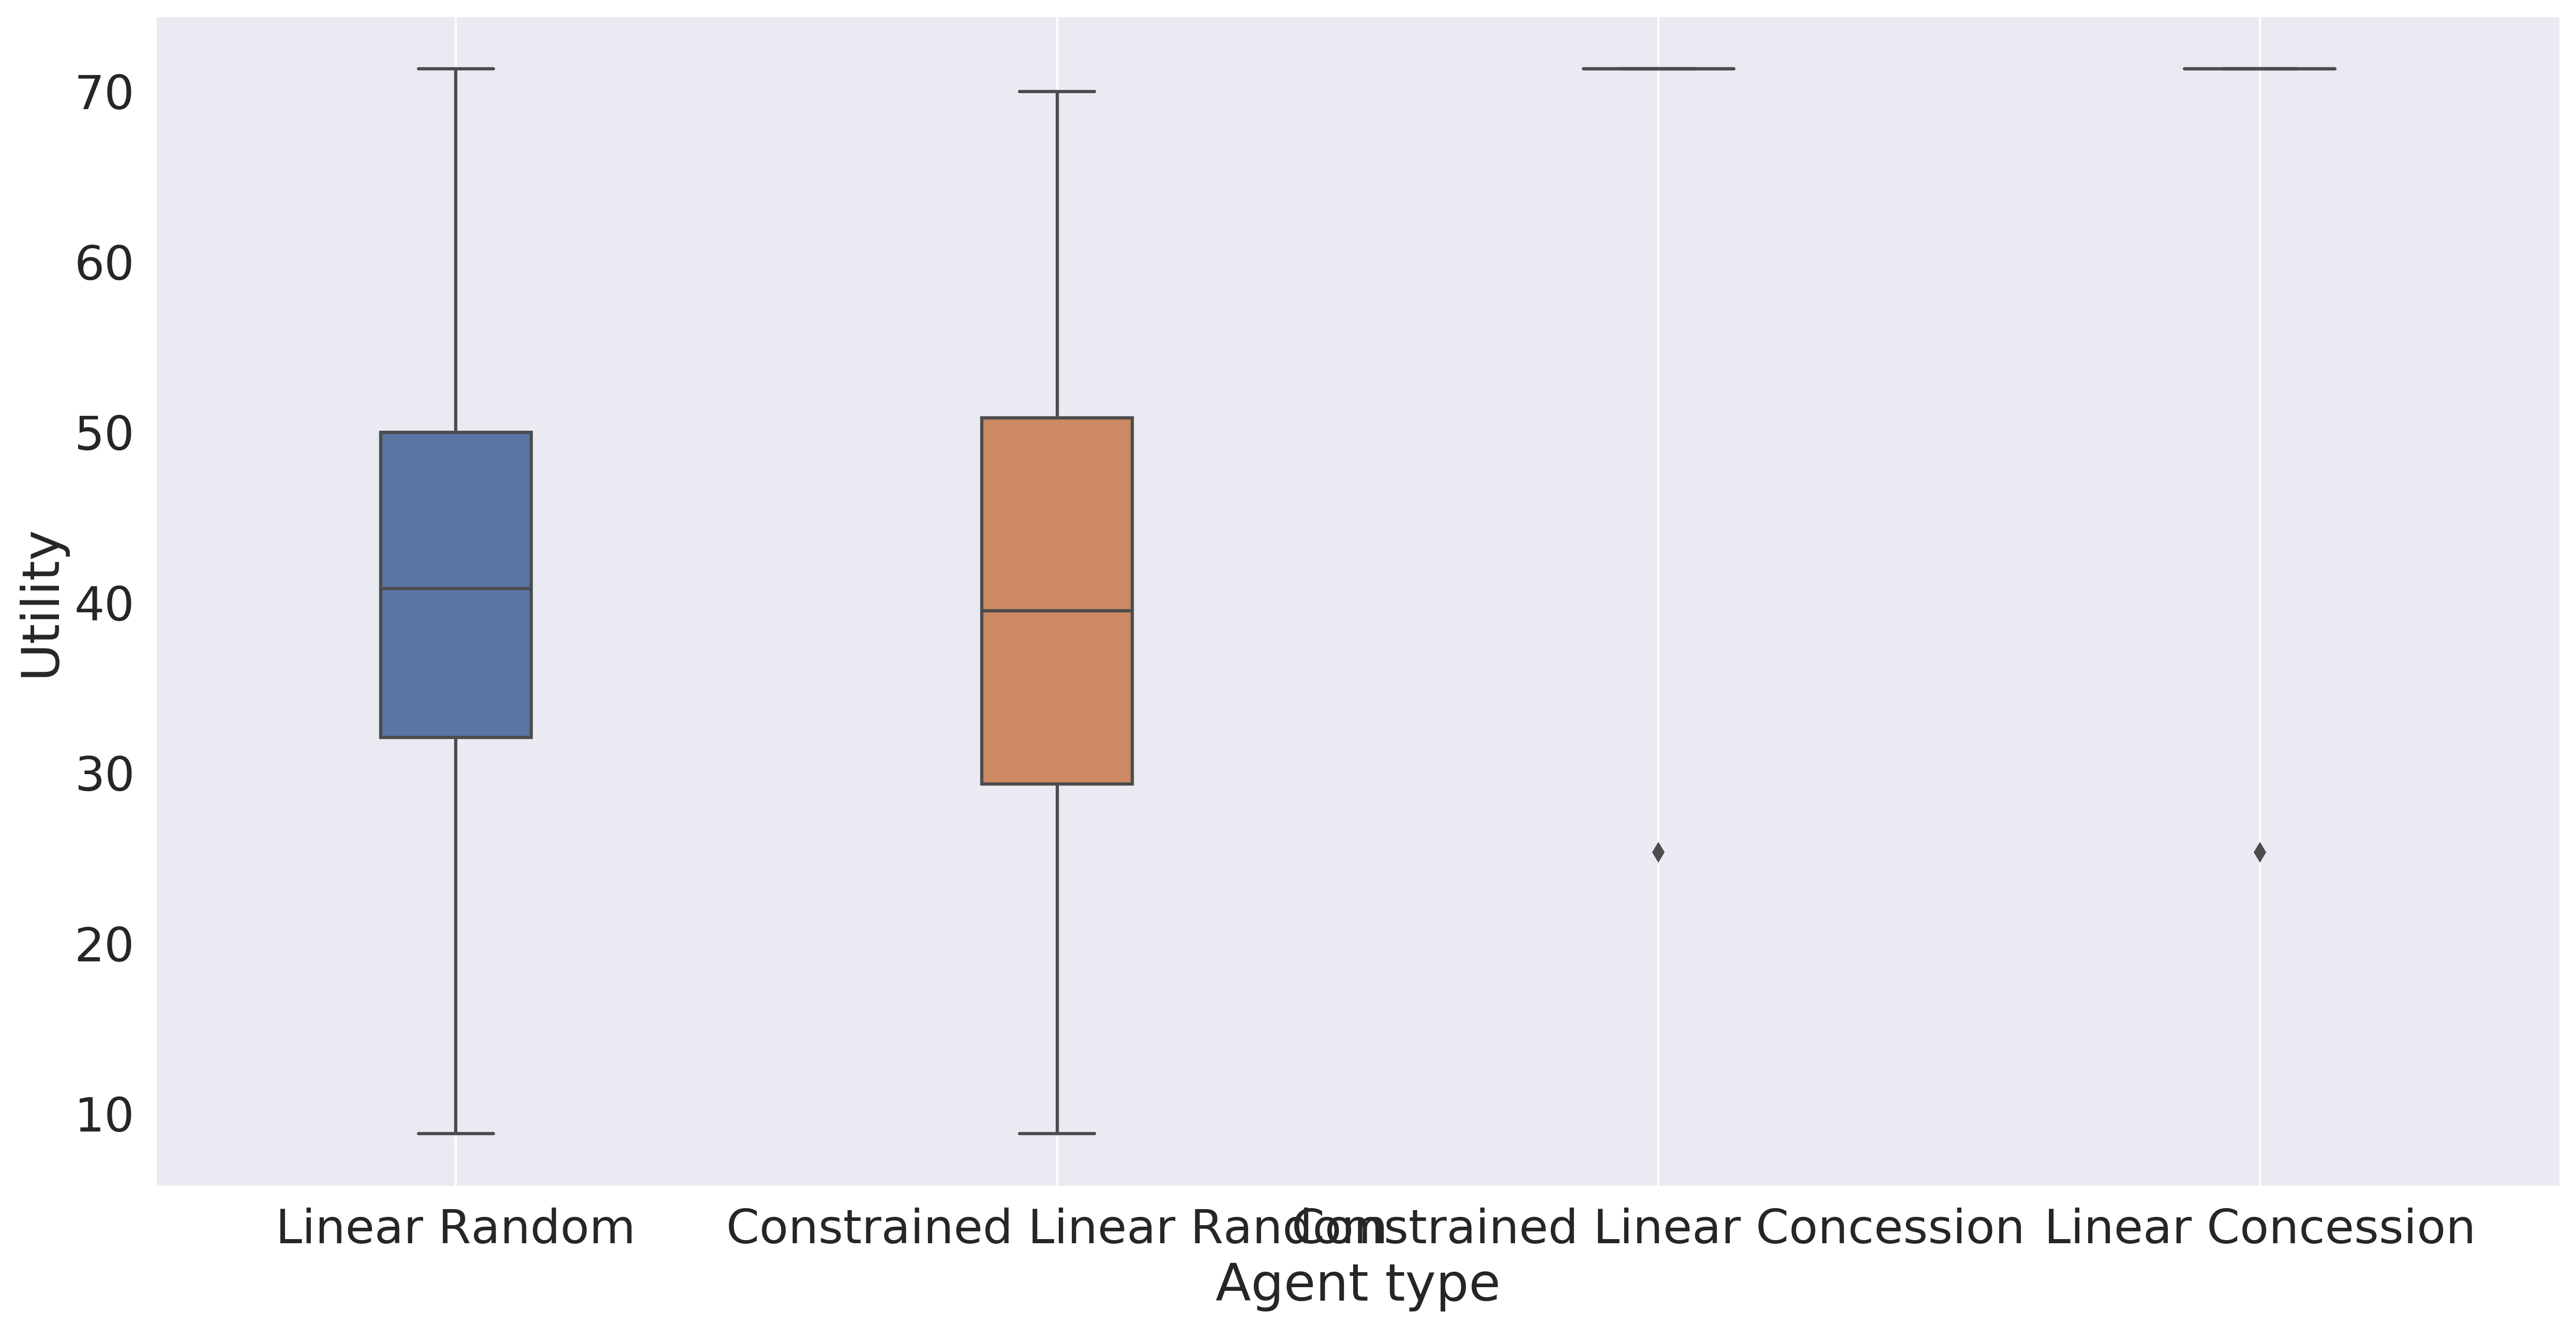

In [29]:
sns.set(font_scale=2)
fig, ax = plt.subplots(1, 1, figsize = (20, 10), dpi=300)
ax = sns.boxplot(x="strat", y="utility", data=results[results['success']], width=0.25)
ax.set_ylabel('Utility')    
ax.set_xlabel('Agent type')
ax.grid()
plt.show()

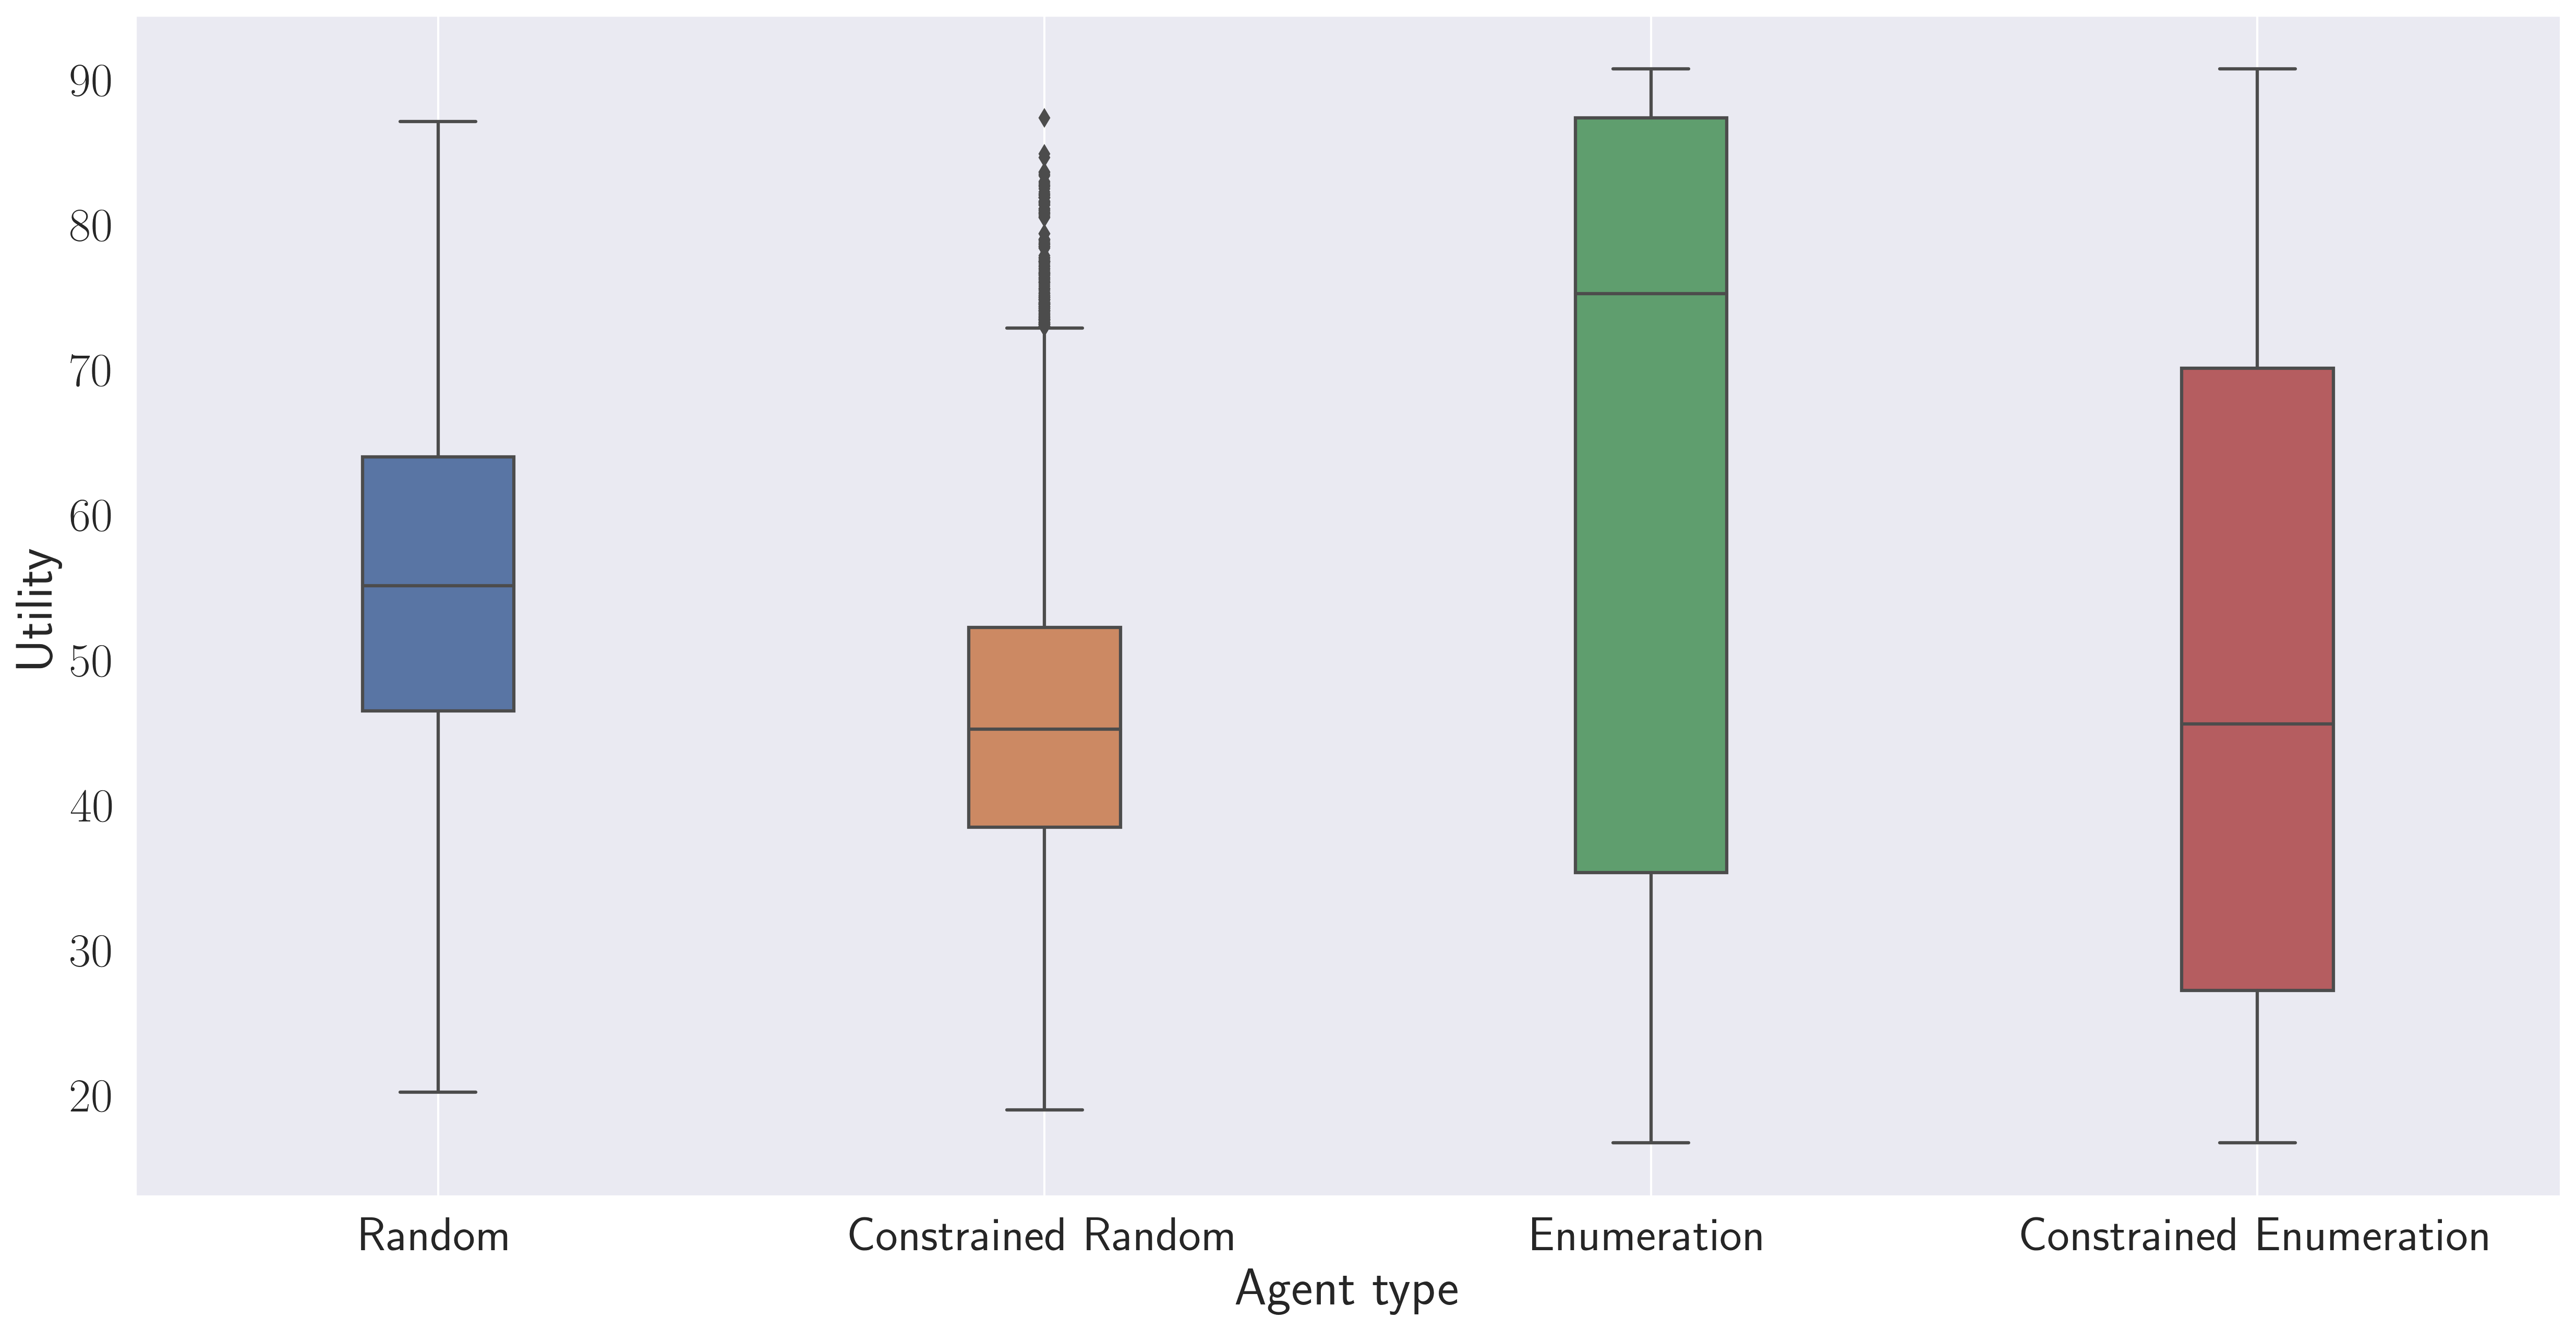

In [8]:
sns.set(font_scale=2)
fig, ax = plt.subplots(1, 1, figsize = (20, 10), dpi=300)
ax = sns.boxplot(x="strat", y="utility", data=results[results['utility'] >= 0], width=0.25, order=order)
ax.set_ylabel('Utility')    
ax.set_xlabel('Agent type')
ax.grid()
plt.show()

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


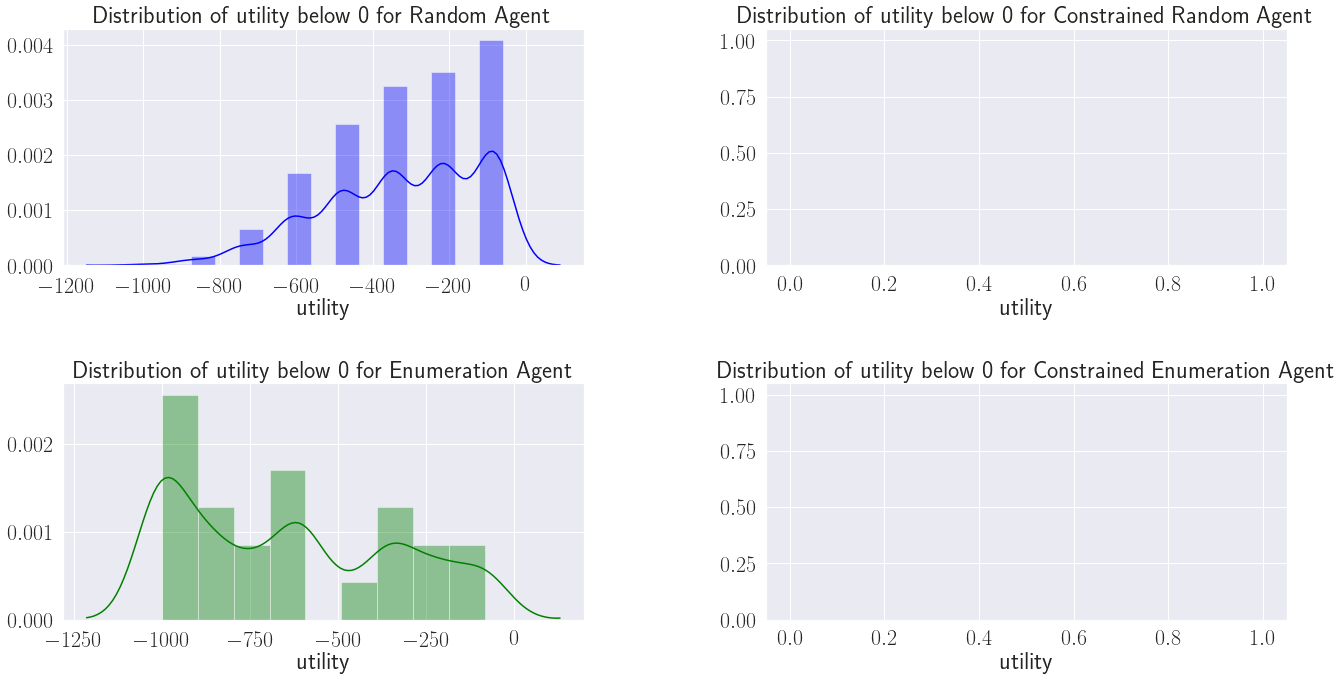

In [9]:
fig, axs = plt.subplots(2, 2,figsize = (20, 10))

sns.distplot(results[(results['utility'] <=0 )&(results['strat'] == 'Random')&(results['success'])]['utility'],ax=axs[0,0],color="blue")
axs[0,0].set_title('Distribution of utility below 0 for Random Agent')

sns.distplot(results[(results['utility'] <=0 )&(results['strat'] == 'Constrained Random')&(results['success'])]['utility'],ax=axs[0,1],color="red")
axs[0,1].set_title('Distribution of utility below 0 for Constrained Random Agent')

sns.distplot(results[(results['utility'] <=0 )&(results['strat'] == 'Enumeration')&(results['success'])]['utility'],ax=axs[1,0],color="green")
axs[1,0].set_title('Distribution of utility below 0 for Enumeration Agent')

sns.distplot(results[(results['utility'] <=0 )&(results['strat'] == 'Constrained Enumeration')&(results['success'])]['utility'],ax=axs[1,1],color="orange")
axs[1,1].set_title('Distribution of utility below 0 for Constrained Enumeration Agent')
plt.subplots_adjust(top=0.92, bottom=0.1, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)
plt.show()

In [46]:
weird = results[((results['success']) & (results["utility"] < 0)) | ((~results['success']) & (results["utility"] >= 0))]


In [47]:
weird[["constr_count", "p_ap_b", "total_message_count", "utility", "opponent_utility"]].describe()

,constr_count,p_ap_b,total_message_count,utility,opponent_utility
count,6629.000000,6.629000e+03,6629.000000,6629.000000,6629.000000
mean,13.370795,1.916566e-02,93.370493,-246.488762,-134.502225
std,5.768683,8.312373e-02,99.136772,363.830677,242.340960
min,0.000000,0.000000e+00,2.000000,-1000.000000,-874.875000
25%,9.000000,0.000000e+00,3.000000,-483.625000,-358.000000
50%,14.000000,8.613709e-08,3.000000,-84.875000,40.000000
75%,18.000000,8.914858e-05,202.000000,61.500000,79.250000
max,23.000000,7.346939e-01,202.000000,87.125000,80.500000


In [48]:
weird['strat'].unique()

array(['Enumeration', 'Random'], dtype=object)

In [14]:
weird.head()

,id,constr_count,rho_a,rho_b,a_accepts,b_accepts,both_accept,p_a,p_b,p_ap_b,success,total_message_count,n_constraints,n_constraints_discovered,n_constraints_opponent_discovered,strat,utility,opponent_utility,opponent_strat
0,/home/venteda/Documents/pyneg/src/scenarios/8c...,1,0.0,0.888889,4941258,2222,1242,0.000251,0.558956,0.000140,True,3,1,0,0,Enumeration,-84.875,80.500,Enumeration
1,/home/venteda/Documents/pyneg/src/scenarios/87...,18,0.0,0.333333,172800,213811,956,0.005532,0.004471,0.000025,True,3,18,0,0,Enumeration,-1000.000,79.250,Enumeration
6,/home/venteda/Documents/pyneg/src/scenarios/87...,20,0.0,0.000000,86400,138240,540,0.006250,0.003906,0.000024,True,2,20,0,0,Random,-211.875,-341.375,Random
36,/home/venteda/Documents/pyneg/src/scenarios/8c...,6,0.0,0.000000,2016840,2222640,661500,0.327988,0.297619,0.097616,True,2,6,0,0,Random,-210.500,-82.375,Random
38,/home/venteda/Documents/pyneg/src/scenarios/f3...,3,0.0,0.000000,3529470,3630312,2222640,0.629738,0.612245,0.385554,True,2,3,0,0,Random,-71.875,-90.625,Random


In [15]:
print("{:.3}% of samples are weird".format(len(weird)/len(results)))

0.0377% of samples are weird


In [50]:
print("{} out of {} of base scenarios contained erroniously marked negotiations.".format(len(weird["id"].unique()),len(results["id"].unique())))

10 out of 10 of base scenarios contained erroniously marked negotiations.


In [51]:
weird.groupby("id")['constr_count'].describe()

,count,mean,std,min,25%,50%,75%,max
id,,,,,,,,
/home/venteda/Documents/pyneg/src/scenarios/3a088646-45b3-47a7-8ec9-2bd30c1b483e,664.0,13.198795,5.897536,0.0,9.0,14.0,18.0,23.0
/home/venteda/Documents/pyneg/src/scenarios/77050719-a86e-4a6c-8183-8b716b0166f8,657.0,13.277017,5.741057,0.0,9.0,14.0,18.0,23.0
/home/venteda/Documents/pyneg/src/scenarios/832145f0-456c-482d-8f5d-db801a08fe55,671.0,13.494784,5.744268,0.0,9.0,14.0,18.0,23.0
/home/venteda/Documents/pyneg/src/scenarios/87f249a0-03f5-4c75-a19f-f2338e252c7f,679.0,13.427099,5.823883,0.0,9.0,14.0,18.0,23.0
/home/venteda/Documents/pyneg/src/scenarios/8cce13a3-7b08-4a35-8639-e0f3ee6dd789,650.0,13.387692,5.782965,0.0,9.0,14.0,18.0,23.0
/home/venteda/Documents/pyneg/src/scenarios/b7b41eb5-a722-4645-8ac3-75c0e2b67674,662.0,13.457704,5.750000,0.0,9.0,14.0,18.0,23.0
/home/venteda/Documents/pyneg/src/scenarios/bbf7a5de-b863-4ba1-bf84-846e50649331,668.0,13.297904,5.763676,0.0,9.0,14.0,18.0,23.0
/home/venteda/Documents/pyneg/src/scenarios/c1ffdd0d-6394-4dcf-a223-2e6fc64df9ae,665.0,13.475188,5.746639,0.0,9.0,14.0,18.0,23.0
/home/venteda/Documents/pyneg/src/scenarios/d9669406-034d-4050-8217-4fefd8fa4eda,660.0,13.401515,5.758229,1.0,9.0,14.0,18.0,23.0


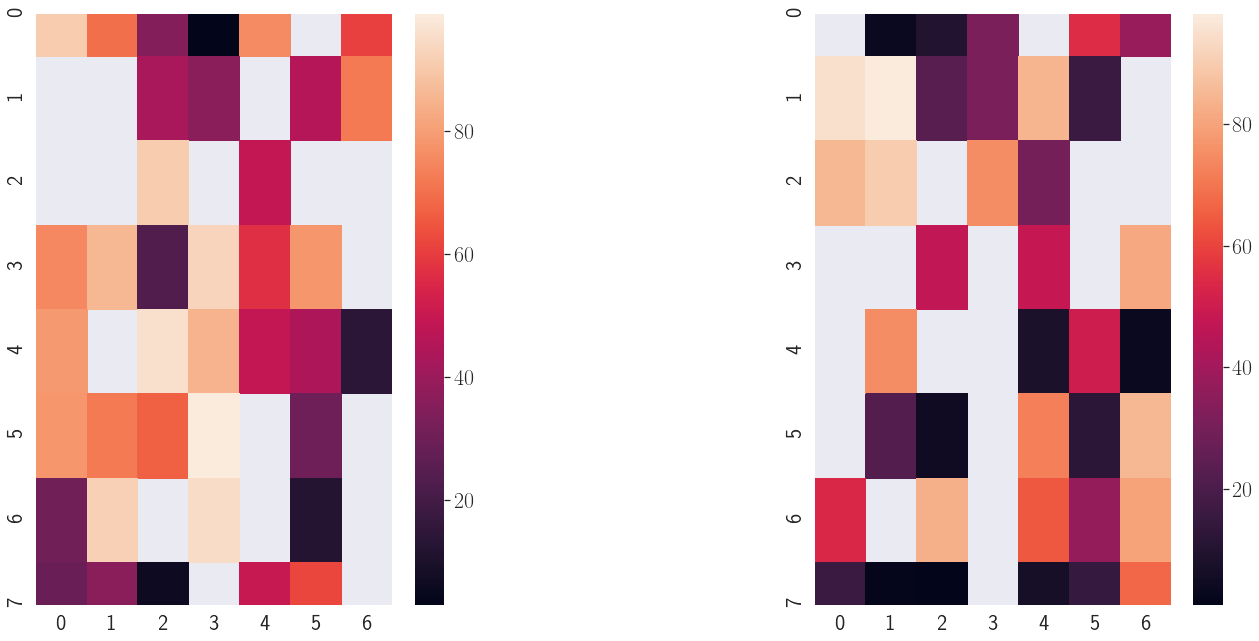

In [71]:
# some seaborn magic from https://stackoverflow.com/questions/36898008/seaborn-heatmap-with-logarithmic-scale-colorbar/50429431
# for log colour scale
a = np.load("../scenarios/87f249a0-03f5-4c75-a19f-f2338e252c7f/18/a.npy").astype(float)
b = np.load("../scenarios/87f249a0-03f5-4c75-a19f-f2338e252c7f/18/b.npy").astype(float)
a[a == -1000] = np.nan
b[b == -1000] = np.nan

fig,axs = plt.subplots(1,2,figsize=(20,10))
sns.heatmap(a,ax=axs[0], mask=np.isnan(a))
sns.heatmap(b,ax=axs[1], mask=np.isnan(b))
plt.subplots_adjust(top=0.92, bottom=0.1, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.75)